# Wasserstein v.s. Sinkhorn

The $p$-Wasserstein distances form the core of optimal transport. In practice, these distances can be difficult to compute. Computation time can be greatly improved by instead using a Sinkhorn distance, which is an entropic regularization of the Wasserstein distance. For instance, the 2-Wasserstein transport plan $P$ between two datasets is chosen by
$$
\arg \min_P  \quad \langle P,M \rangle
$$
where $M_{ij} = d^2(x_i,x_j)$. The transport plan $P$ tends to be quite sparse. Indeed, if both datasets have the same number of points and all points are given equal weight, $P$ can always be chosen to be a permutation matrix.

The Sinkhorn transport plan $P^\lambda$, by contrast, is given by
$$
\arg \min_{P^\lambda} \quad \langle P^\lambda,M \rangle + \frac{1}{\lambda}h(P^\lambda)
$$
where $h(P^\lambda)$ is the entropy of $P^\lambda$ viewed as a distribution. This approach exhibits multiple virtues.

1) **It's Unique.** This minimization problem has a unique solution by strict convexity of the entropy function.

2) **It's Smoother.** The Wasserstein transport plan is highly sensitive to the distances between datapoints. Moving the dataset slightly could cause the plan to jump discontinuously. Sinkhorn transport plans tend to smooth over these jumps.

3) **It's Fast.** A Sinkhorn plan can be computed faster than a Wasserstein plan using the Sinkhorn-Knopp algorithm.

To get a feel for the kinds of plans that the Sinkhorn distance can produce, let's look at an example.

# Generating Data

We will sample points from two curves in the plane in an effort to maximize the beauty of future plots.

In [1]:
import ot
import numpy as np
from numpy import linalg as la
from math import sqrt, atan, pi, sin, cos
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import cvxpy as cp

In [2]:
# Generate point cloud X
n = 100
Xtimes = np.linspace(-pi,pi,n)
X = np.array([[t + sin(2*t), 2*cos(t)]
                    for t in Xtimes])

# Generate point cloud Y
Ytimes = np.linspace(0,pi,n)
Y = np.array([[t*sin(4*t), t*cos(4*t)]
                    for t in Ytimes])

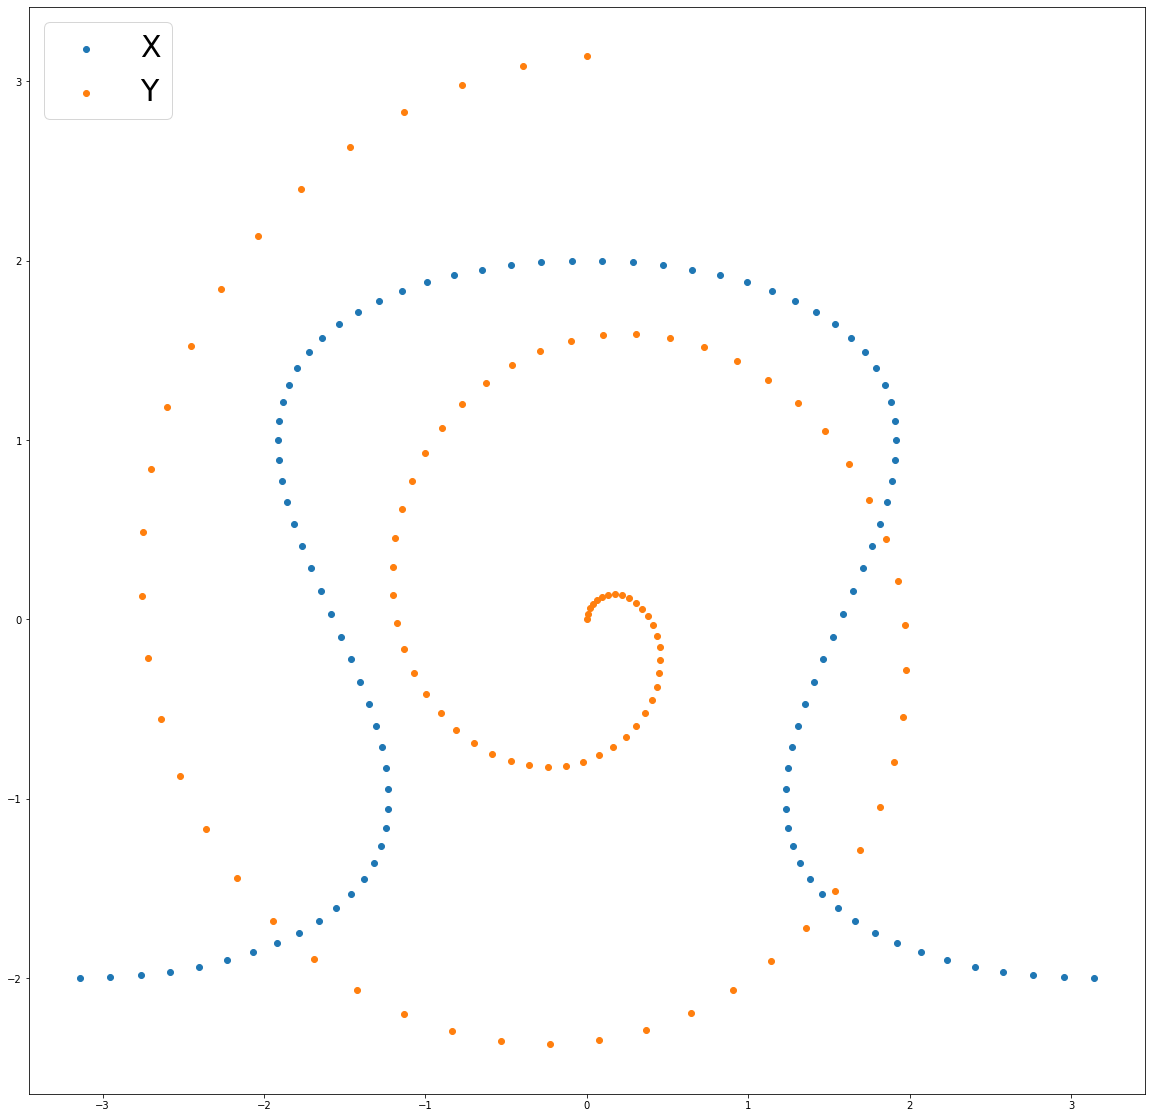

In [3]:
# Plot datasets
fig = plt.figure(figsize=(20,20))
plt.scatter(X.T[0], X.T[1], label= "X")
plt.scatter(Y.T[0], Y.T[1], label = "Y")
plt.legend(loc="upper left",fontsize=30 )

# Setup
In preparation for some optimal transport, we'll compute the cost matrix $M$. We'll also define a function that plots the two datasets and a transport plan. The transport plan plots will draw lines between points that are coupled by the plan, with line thickness proportional to the mass transported between that pair of points.

In [4]:
# Compute cost matrix
M = [[la.norm(X[i] - Y[j])**2 for j in range(n)] for i in range(n)]
M = np.array(M)

In [5]:
def showTransportPlan(X,Y,P):
    fig= plt.figure(figsize=(20,20))
    ax = fig.add_subplot()
    plt.scatter(X.T[0],X.T[1])
    plt.scatter(Y.T[0],Y.T[1])
    lines = []
    weights = []
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            lines.append((x,y))
            weights.append(P[i][j])
    lc = mc.LineCollection(lines, linewidths=weights)
    ax.add_collection(lc)

# 2-Wasserstein Transport Plan
Let's start with a Wasserstein transport plan. I'll use the 2-Wasserstein distance since I have a homebrew implementation via the CVX library. This implementation actually doesn't use the cost matrix $M$, but instead uses $X$ and $Y$ themselves.

In [6]:
#Construct linear program
ones = np.ones(n)
P = cp.Variable((n,n))
objective = cp.Maximize(cp.trace(P@Y@np.transpose(X)))
constraints = [ones @ P == 1, P @ np.transpose(ones) == 1, P >= 0]
problem = cp.Problem(objective, constraints)

#Solve linear program
problem.solve()
P_wass = P.value

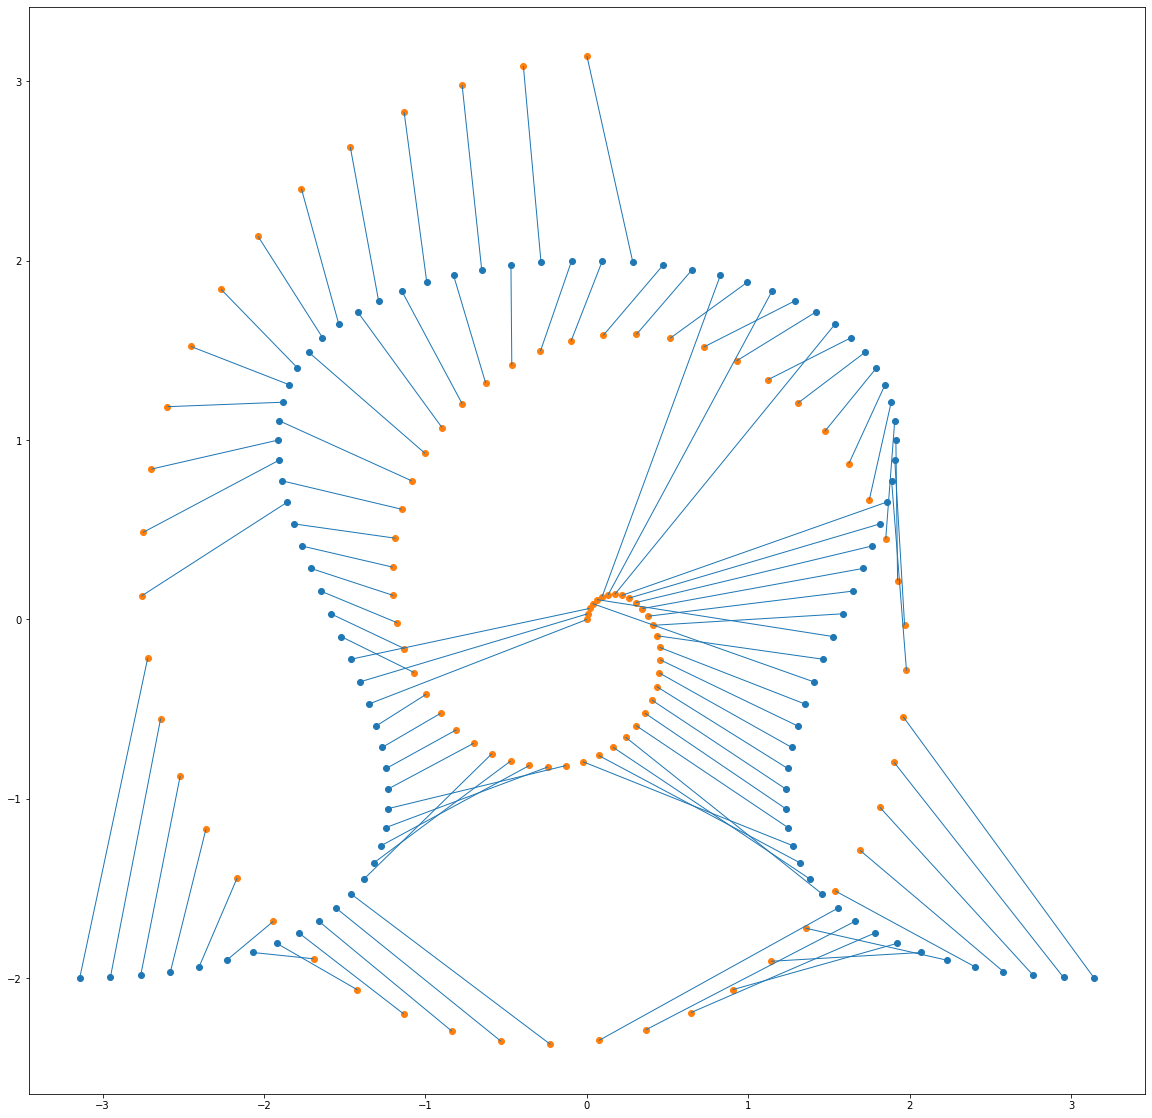

In [7]:
showTransportPlan(X,Y,P_wass)

As we can see, the Wasserstein transport plan defines a perfect matching between $X$ and $Y$; the transport plan is a binary matrix. This is an extremely *low entropy* coupling between $X$ and $Y$.

# Sinkhorn Transport Plan

Now we'll compute the tranport plan defined by the Sinkhorn distance and see how it differs. Remember, the Sinkhorn distance is designed to favor high-entropy transport plans, so it should look quite different from the plan offered by the 2-Wasserstein distance.

We will try the Sinkhorn distance with a few choices of $\lambda$. The lower the value of $\lambda$, the higher the penalty for entropy, and the more we expect the transport plan to differ from the deterministic coupling given above.

## Sinkkhorn with $\lambda = 10$

In [8]:
lam = 10
P_sink10 = ot.sinkhorn(np.ones(n),np.ones(n),M,1/lam)

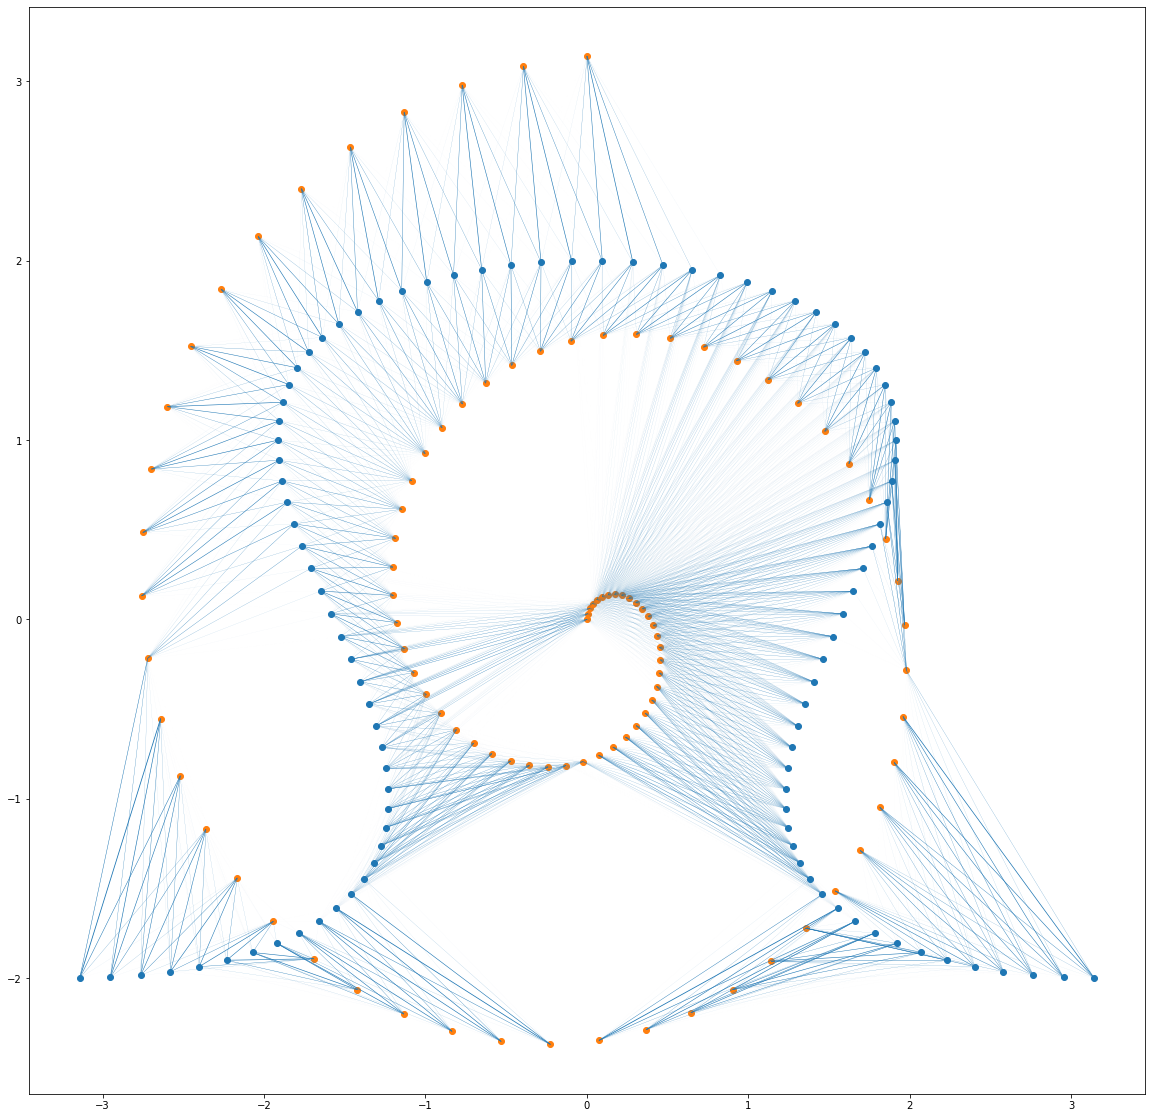

In [9]:
# Plot transport plan
# Double P for thicker lines
showTransportPlan(X,Y,2*P_sink10)

## Sinkhorn with $\lambda = 1$

In [10]:
lam = 1
P_sink1 = ot.sinkhorn(np.ones(n),np.ones(n),M,1/lam)

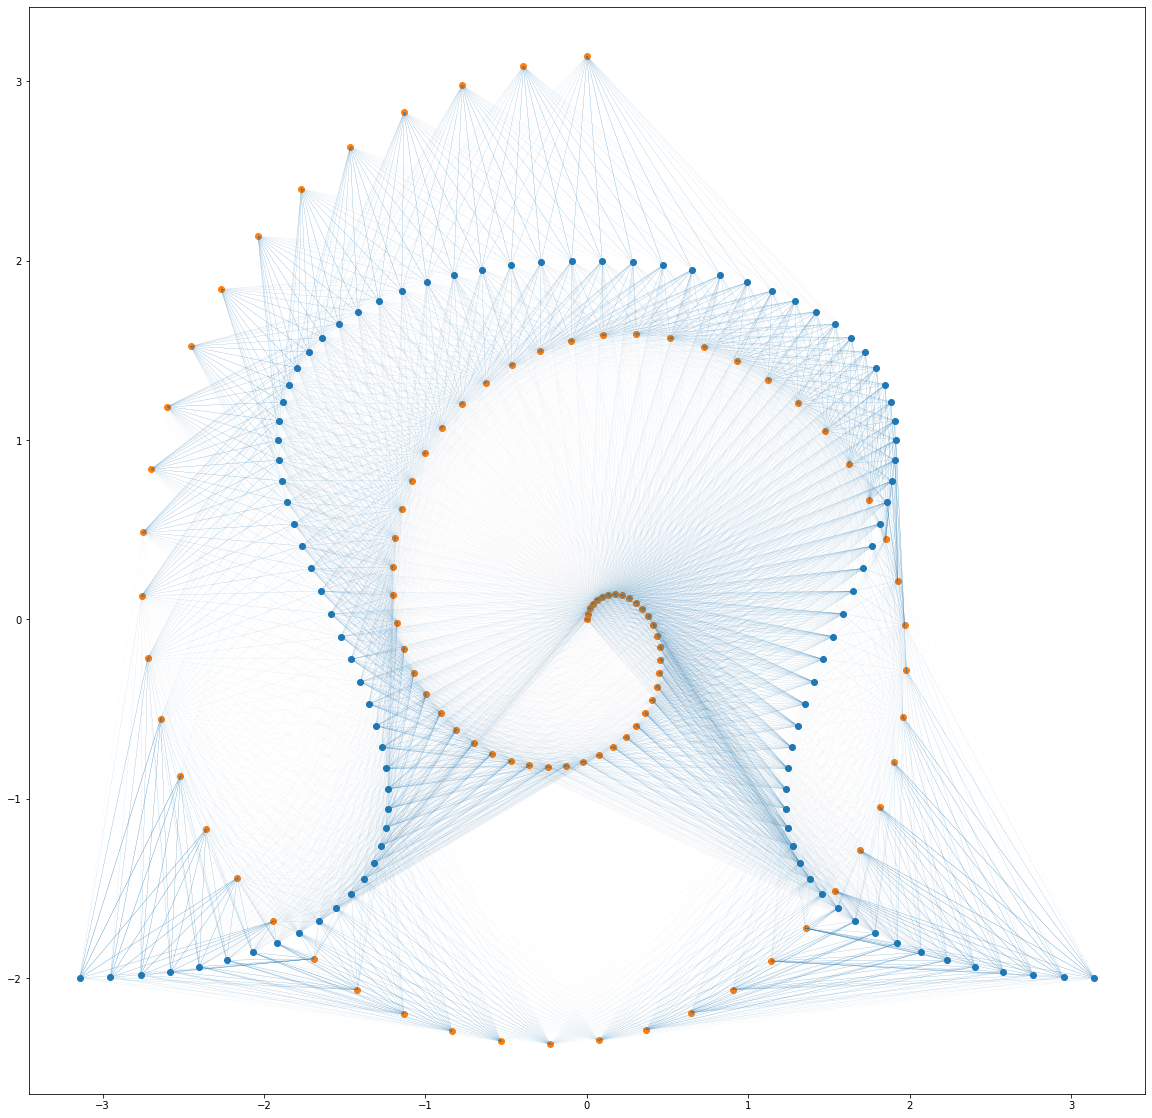

In [11]:
# Plot transport plan
# Double P for thicker lines
showTransportPlan(X,Y,2*P_sink1)

## Sinkhorn with $\lambda = 0.1$

In [12]:
lam = 0.1
P_sink01 = ot.sinkhorn(np.ones(n),np.ones(n),M,1/lam)

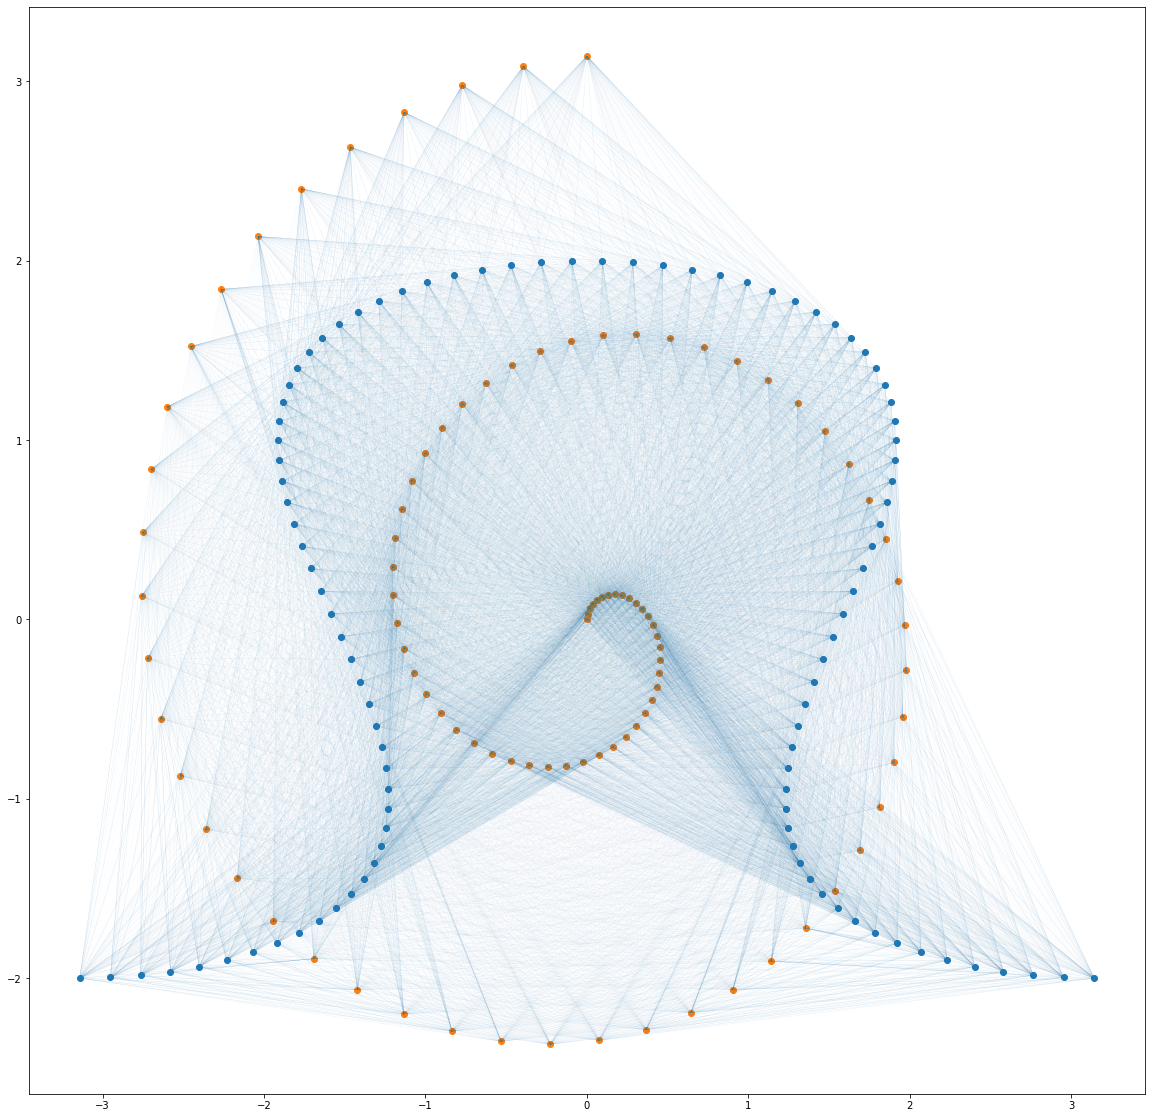

In [13]:
# Plot transport plan
# Double P for thicker lines
showTransportPlan(X,Y,2*P_sink01)